# TensorFlow

## Load the Beans Dataset

In [1]:
import tensorflow as tf
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter

# Enable eager execution
tf.enable_v2_behavior()

In [2]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True
    )

print(bn_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete0UXNLD/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete0UXNLD/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete0UXNLD/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir=PosixGPath('/tmp/tmpgi4g7su5tfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable

## Split the Data into Train Dataset & Test Dataset

In [3]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [4]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [5]:
print(bn_info.features.shape)
print(bn_info.features.dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': tf.uint8, 'label': tf.int64}
(500, 500, 3)
<dtype: 'uint8'>


In [6]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


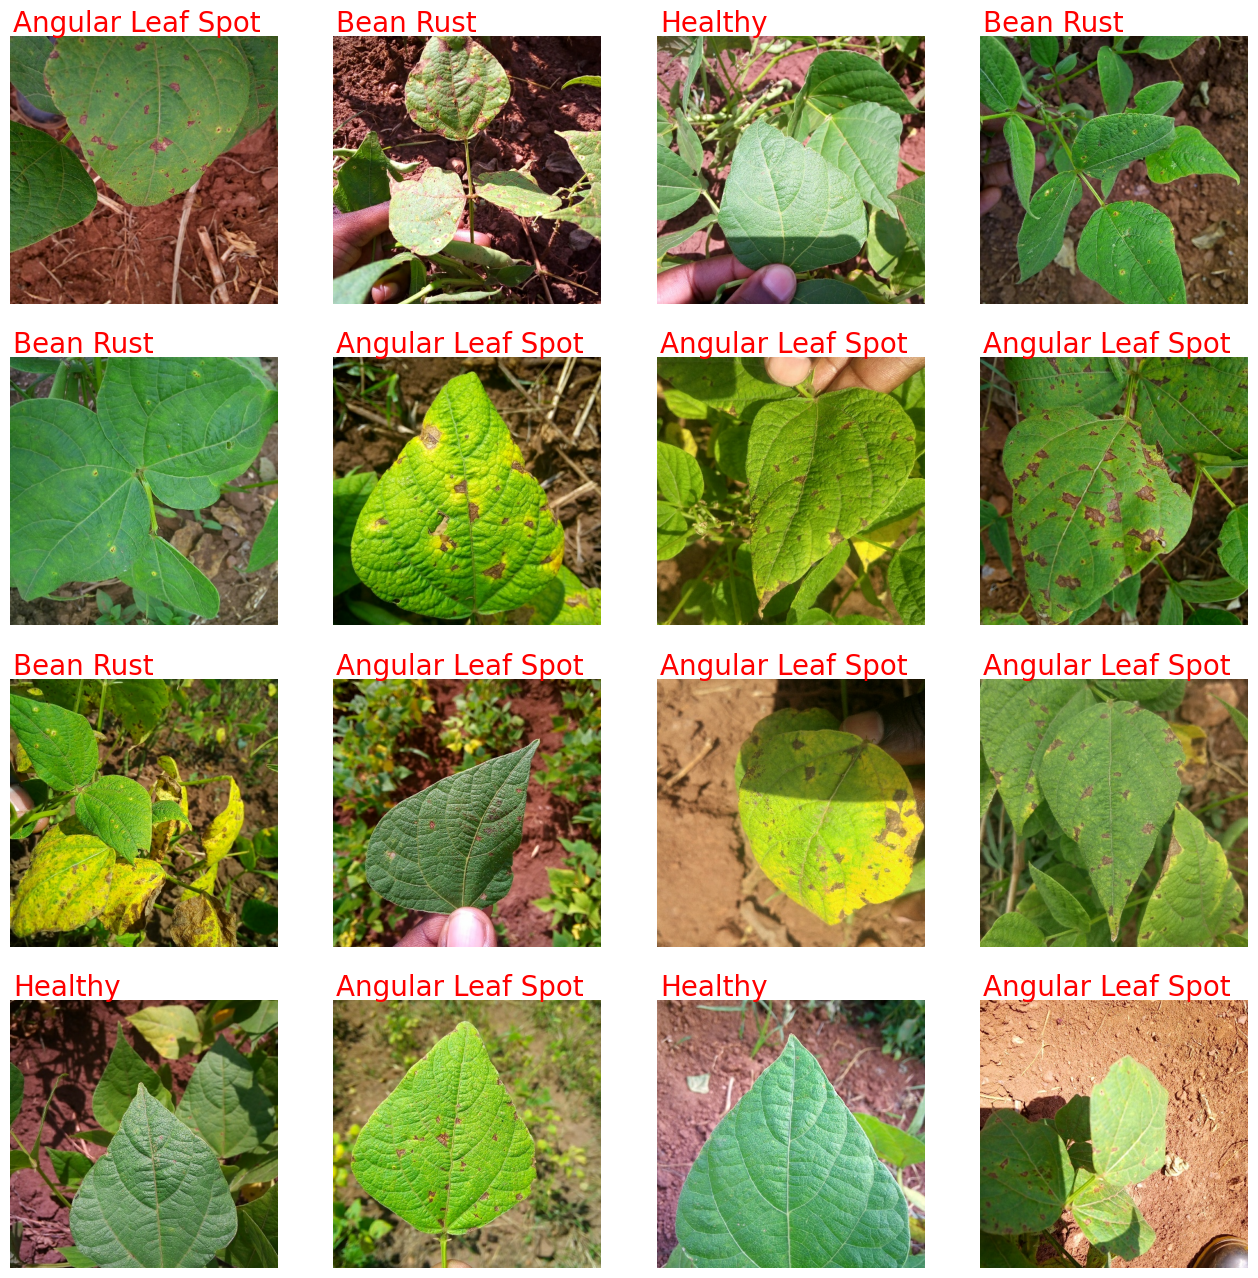

In [9]:
# take out one batch that is 32 images
example = bn_train.take(1)
# each batch has two componets, image and label
# sample=(image, lable)
for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    # we label the subplots using names instead of magic numbers such as 0, 1 and 2
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))
    plt.axis('off')

## Build CNN Model to Perform Image Classification

In [10]:
model = models.Sequential()

# Get the image size uisng codes instead of using magic # (32, 32, 3)
input_shape = image.shape
print(f"The input shape = {input_shape[1:]}")

# The 1st Convolution Layer has 32 Filters, w/ the Output has 32 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape[1:]))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D(2,2))

# The 2nd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D(2,2))

# The 2nd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D(2,2))

# The 3rd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 2*2.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Convert feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))

# Add Dropout Layer
model.add(layers.Dropout(.2))

# Last Layer must have 10 Neuron to Match the Label
model.add(layers.Dense(10))

model.summary()

The input shape = (500, 500, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoo

In [11]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
              )

In [12]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                            patience = 3
                                            )
history = model.fit(bn_train, epochs = 20,
                    validation_data = bn_validation, callbacks = [callback], verbose = 1
                    )

Epoch 1/20
33/33 [==============================] - 25s 282ms/step - loss: 1.6119 - accuracy: 0.3501 - val_loss: 1.0588 - val_accuracy: 0.4211
Epoch 2/20
33/33 [==============================] - 7s 221ms/step - loss: 0.9416 - accuracy: 0.5513 - val_loss: 0.8537 - val_accuracy: 0.6165
Epoch 3/20
33/33 [==============================] - 8s 235ms/step - loss: 0.8753 - accuracy: 0.6093 - val_loss: 0.7437 - val_accuracy: 0.6692
Epoch 4/20
33/33 [==============================] - 7s 224ms/step - loss: 0.7448 - accuracy: 0.6867 - val_loss: 0.6855 - val_accuracy: 0.6917
Epoch 5/20
33/33 [==============================] - 8s 225ms/step - loss: 0.6772 - accuracy: 0.7244 - val_loss: 0.6844 - val_accuracy: 0.6692
Epoch 6/20
33/33 [==============================] - 8s 239ms/step - loss: 0.6296 - accuracy: 0.7476 - val_loss: 0.6630 - val_accuracy: 0.7218
Epoch 7/20
33/33 [==============================] - 8s 227ms/step - loss: 0.5259 - accuracy: 0.7843 - val_loss: 0.7499 - val_accuracy: 0.6692
Epoch

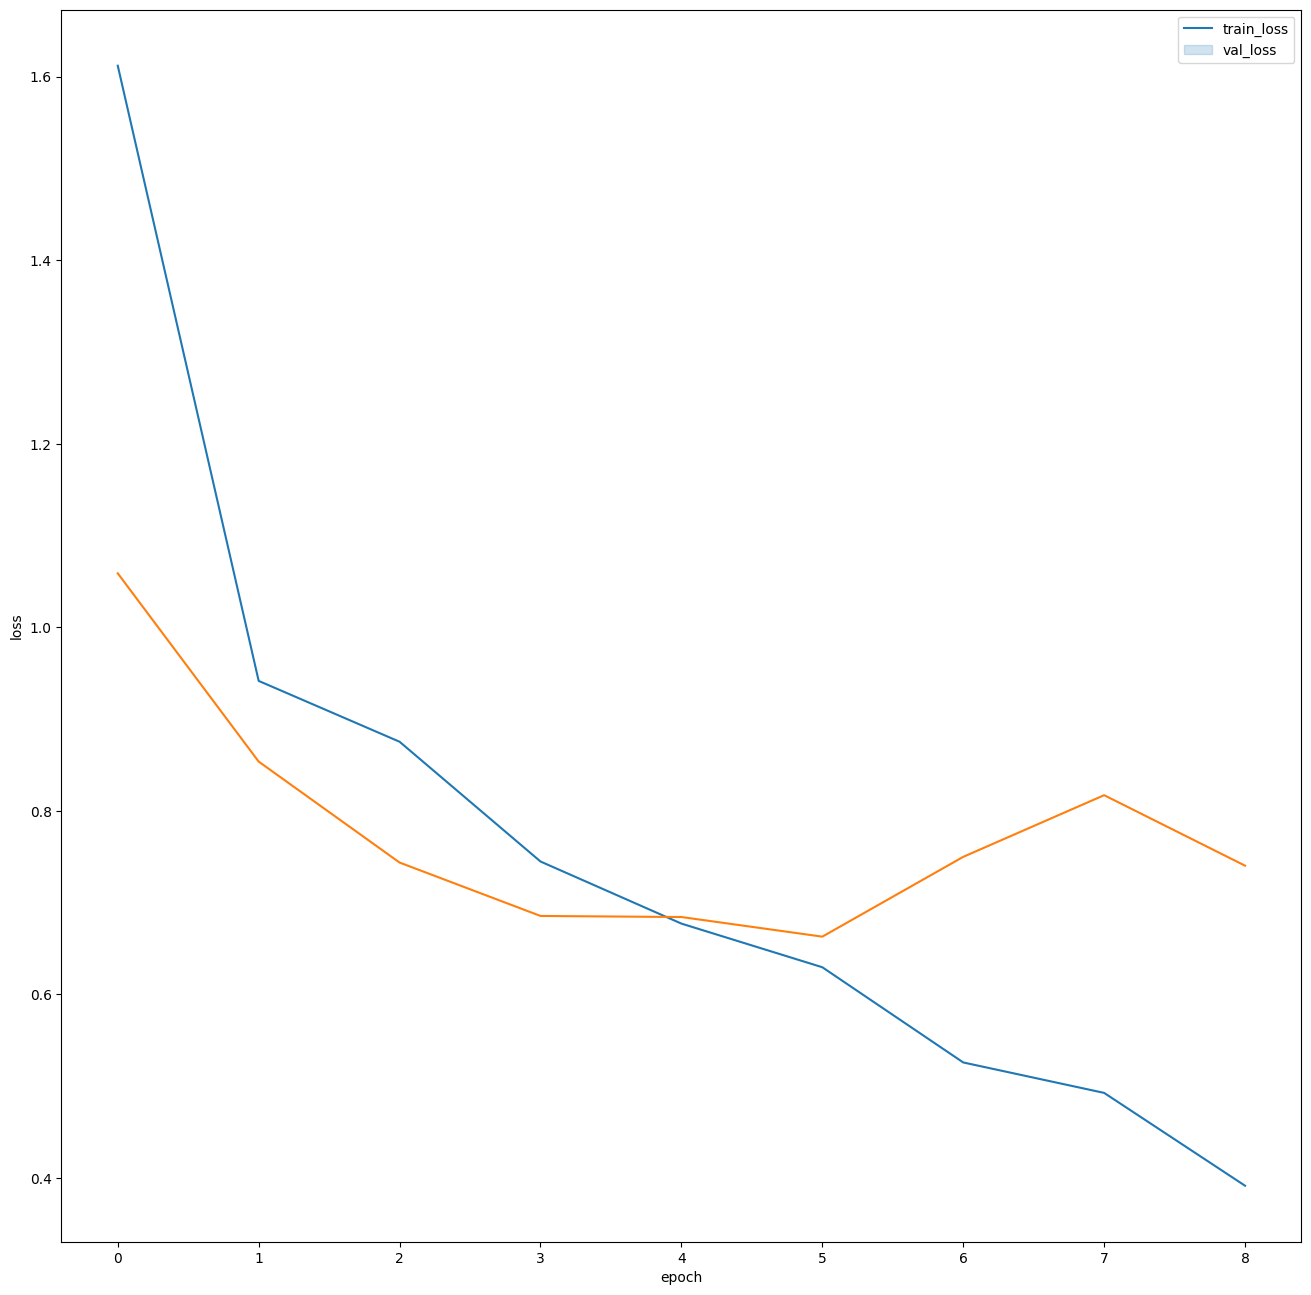

In [13]:
# Evaluate the Model
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

# Plot Train Loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history)

# Plot Validation Loss
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history)

# Add Legends
plt.legend(labels = ['train_loss', 'val_loss'])

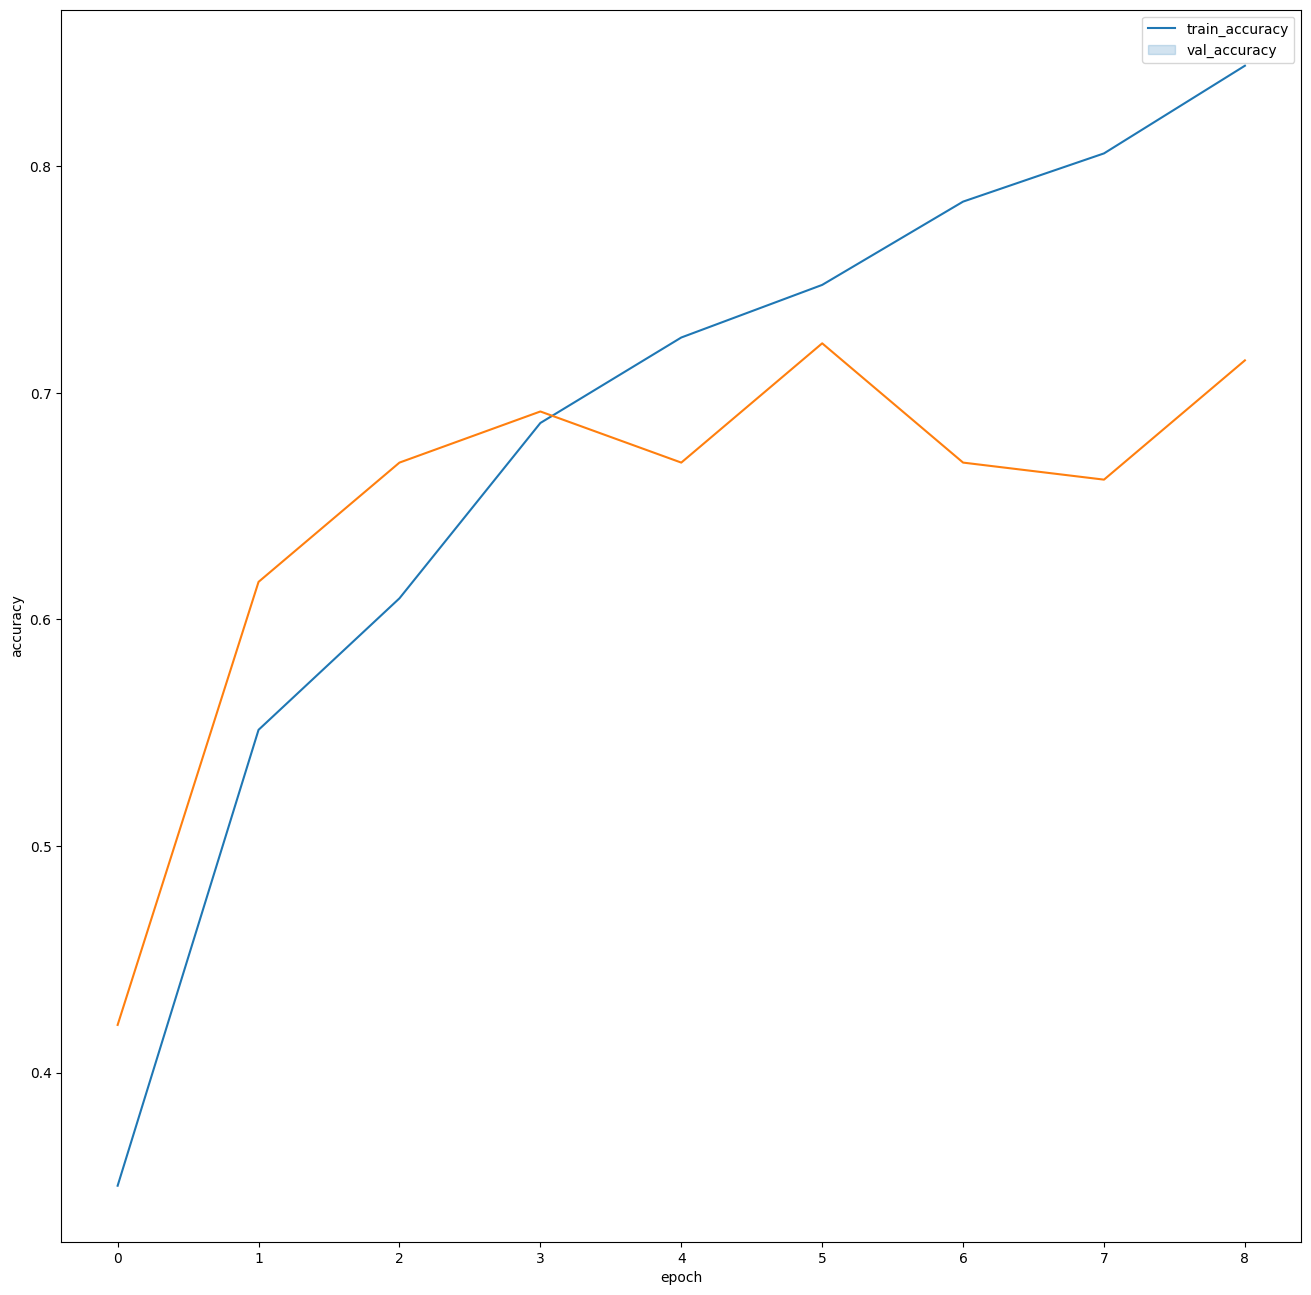

In [14]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history)

# Plot Validation Accuracy Loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history)

# Add Legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

In [15]:
test_loss, test_acc = model.evaluate(bn_test, verbose = 0)

print(f"Test Loss = {test_loss:.2f} & Test Accuracy = {test_acc:.2f}")

Test Loss = 0.73 & Test Accuracy = 0.74


### I believe that is slightly towards overfitting because val_loss is greater than train_loss at the end epochs. Also train_accuracy is greater than val_accurarcy.

## Data Augmentation Techniques to Build a Better CNN Model w/ the Same Network Architecture

In [16]:
data_aug = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                              input_shape),
        tf.keras.layers.experimental.preprocessing.RandomRotation(.1),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor = .1, width_factor = .1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (.1, .1))
    ]
)


In [17]:
 # Get the image size uisng codes instead of using magic # (32, 32, 3)
input_shape = image.shape
print(f"The input shape = {input_shape[1:]}")


model = tf.keras.Sequential([
    # Data Augmentation
    data_aug
])

# The 1st Convolution Layer has 32 Filters, w/ the Output has 32 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape[1:]))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D())

# The 2nd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D())

# The 2nd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 3*3.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Followed by 2*2 Pooling Window
model.add(layers.MaxPooling2D())

# The 3rd Convolution Layer has 64 Filters, w/ the Output has 64 Channels. The size of the filter is 2*2.
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

# Convert feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))

# Add Dropout Layer
model.add(layers.Dropout(.2))

# Last Layer must have 10 Neuron to Match the Label
model.add(layers.Dense(10))

The input shape = (500, 500, 3)


In [18]:
model.build(input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 500, 500, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 498, 498, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 249, 249, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 247, 247, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 123, 123, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 121, 121, 64)       

In [19]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 500, 500, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 498, 498, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 249, 249, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 247, 247, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 123, 123, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 121, 121, 64)       

In [20]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)
epochs = 20
history = model.fit(bn_train, validation_data = bn_validation, epochs = epochs, callbacks = [callback], verbose = 1)

Epoch 1/20
33/33 [==============================] - 11s 252ms/step - loss: 1.6641 - accuracy: 0.3578 - val_loss: 1.0473 - val_accuracy: 0.3684
Epoch 2/20
33/33 [==============================] - 8s 250ms/step - loss: 1.0476 - accuracy: 0.4903 - val_loss: 1.1020 - val_accuracy: 0.5113
Epoch 3/20
33/33 [==============================] - 8s 256ms/step - loss: 0.9315 - accuracy: 0.5832 - val_loss: 0.7388 - val_accuracy: 0.6692
Epoch 4/20
33/33 [==============================] - 8s 242ms/step - loss: 0.8418 - accuracy: 0.6373 - val_loss: 0.7165 - val_accuracy: 0.7293
Epoch 5/20
33/33 [==============================] - 8s 254ms/step - loss: 0.7980 - accuracy: 0.6518 - val_loss: 0.7053 - val_accuracy: 0.7143
Epoch 6/20
33/33 [==============================] - 8s 246ms/step - loss: 0.7569 - accuracy: 0.6896 - val_loss: 0.8212 - val_accuracy: 0.6165
Epoch 7/20
33/33 [==============================] - 8s 251ms/step - loss: 0.7520 - accuracy: 0.6963 - val_loss: 0.7476 - val_accuracy: 0.6692
CPU t

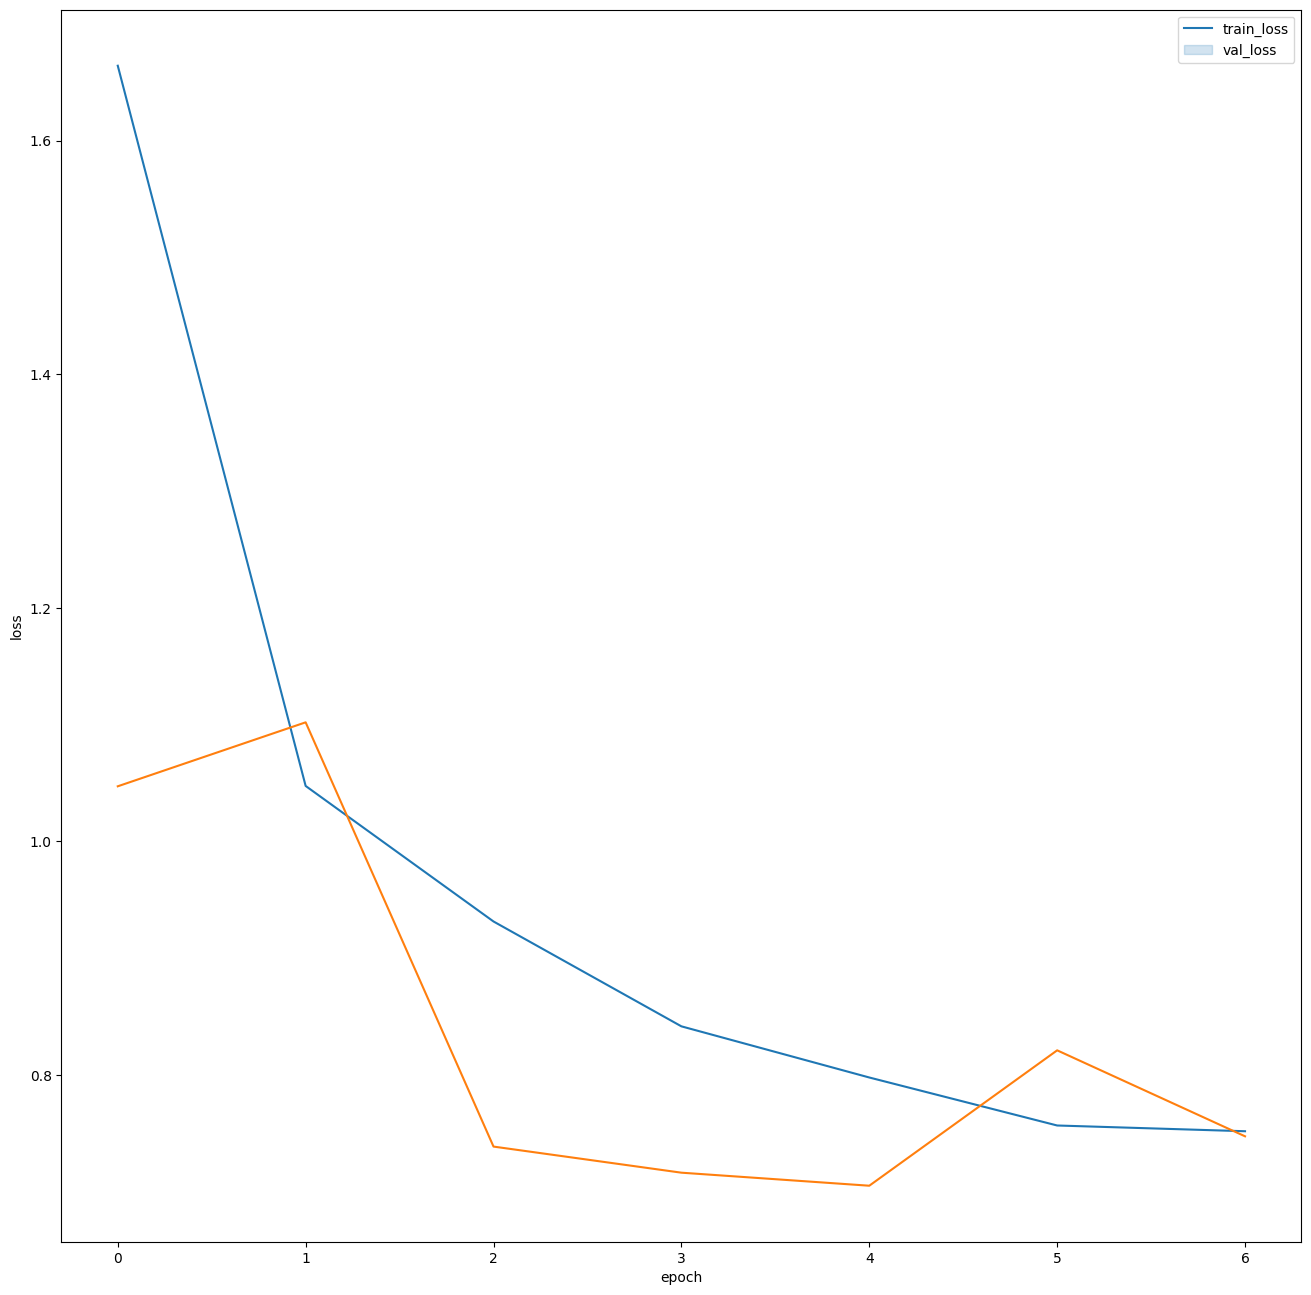

In [21]:
# Evaluate the Model
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

# Plot Train Loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history)

# Plot Validation Loss
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history)

# Add Legends
plt.legend(labels = ['train_loss', 'val_loss'])

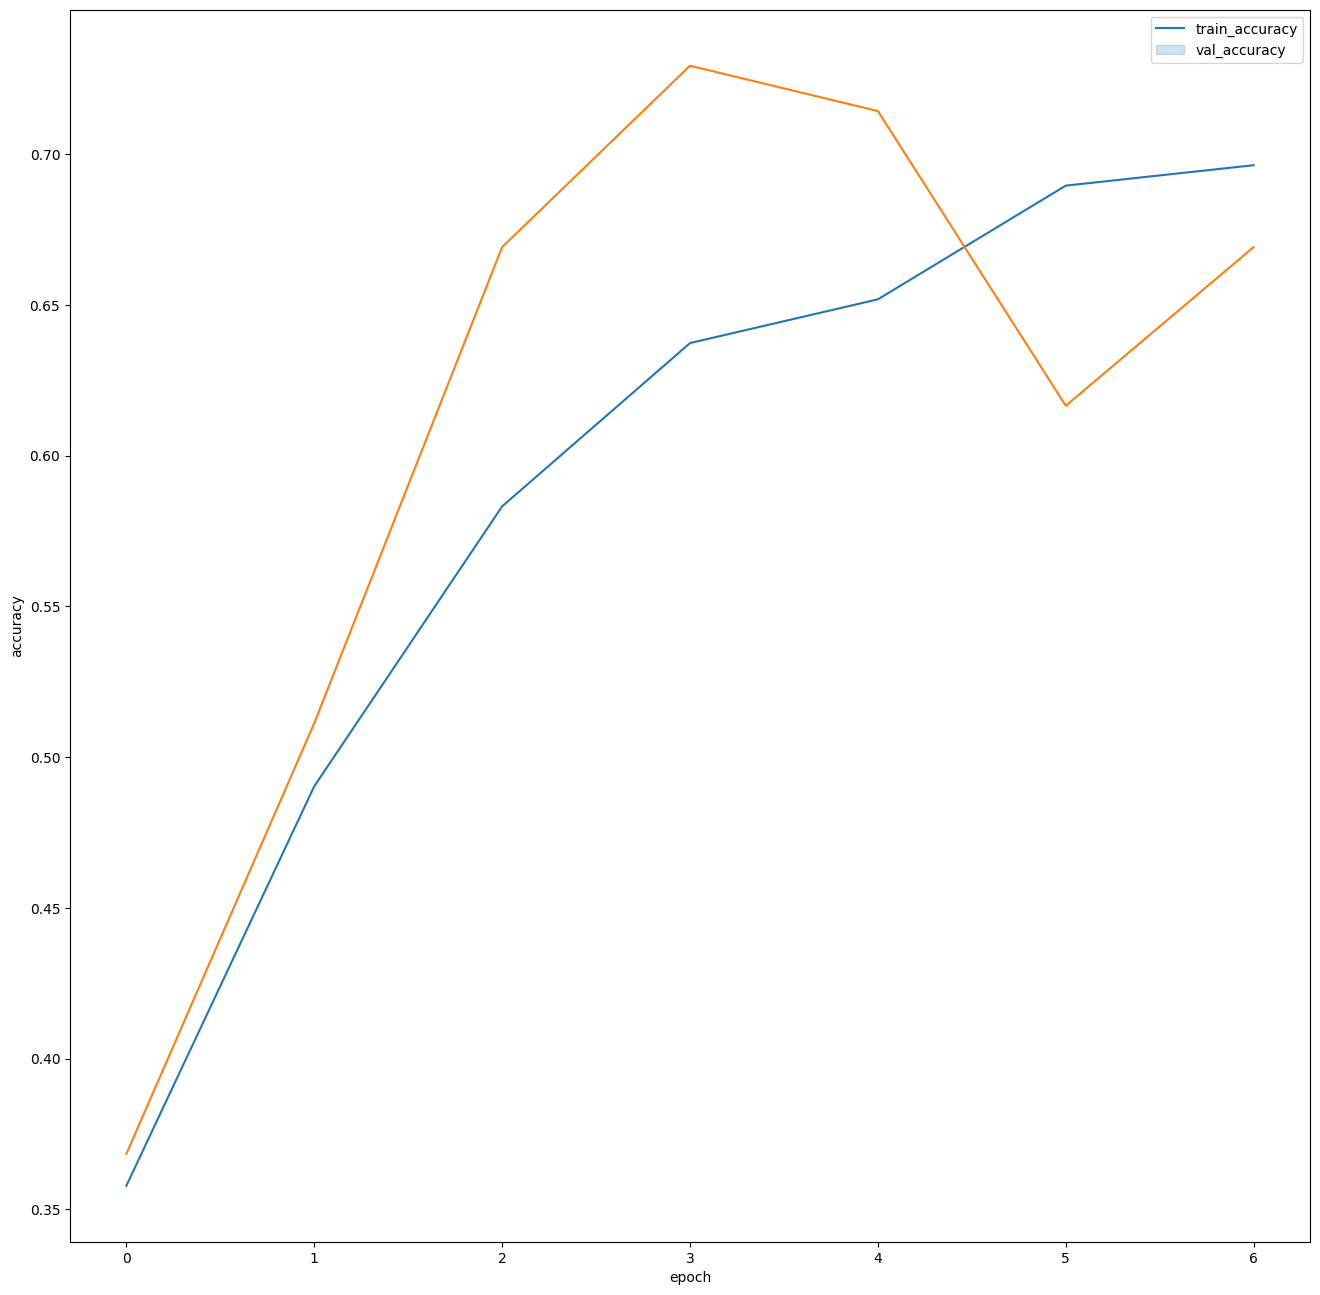

In [22]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history)

# Plot Validation Accuracy Loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history)

# Add Legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

In [23]:
test_loss, test_acc = model.evaluate(bn_test, verbose = 0)

print(f"Test Loss = {test_loss:.2f} & Test Accuracy = {test_acc:.2f}")

Test Loss = 0.74 & Test Accuracy = 0.60


## Transfer Learning to Build a Better CNN Model by Choosing a Pre-Trained Model

In [33]:
MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape[1:],
                                                                include_top = False, # Remove the Fully-Connected Layer
                                                                weights = 'imagenet'
                                                                ) # Pre-Training on ImageNet

12683000/12683000 [==============================] - 0s 0us/step


In [34]:
MobileNetV3Large_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 500, 500, 3)          0         ['input_7[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 250, 250, 16)         432       ['rescaling_6[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 250, 250, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [39]:
MobileNetV3Large_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [40]:
image_batch, label_batch = next(iter(bn_train))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 960)


In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [42]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 245760)


In [43]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)

print(f"Size of the Predicted Value for a given Batch = {prediction_batch.shape}")

Size of the Predicted Value for a given Batch = (32, 5)


In [46]:
inputs = tf.keras.Input(shape = input_shape[1:])

x = data_aug(inputs)

x = preprocess_input(x)

x = MobileNetV3Large_model(x, training = False)

x = global_average_layer(x)

x = tf.keras.layers.Dropout(.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [47]:
learning_rate = .0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
              )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 16, 16, 960)       2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 245760)            0         
                                                                 
 dropout_2 (Dropout)         (None, 245760)            0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1228805   
                                                             

In [48]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuarcy', patience = 3)
epochs = 20
history = model.fit(bn_train,
                    validation_data = bn_validation,
                    epochs = epochs,
                    callbacks = [callback],
                    verbose = 1
                    )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 2.1754 - accuracy: 0.3259

33/33 [==============================] - 18s 332ms/step - loss: 2.1754 - accuracy: 0.3259 - val_loss: 1.2456 - val_accuracy: 0.3308
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 1.4271 - accuracy: 0.3443

33/33 [==============================] - 8s 254ms/step - loss: 1.4271 - accuracy: 0.3443 - val_loss: 1.0798 - val_accuracy: 0.4511
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 1.3897 - accuracy: 0.3472

33/33 [==============================] - 9s 263ms/step - loss: 1.3897 - accuracy: 0.3472 - val_loss: 1.0835 - val_accuracy: 0.4361
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 1.4426 - accuracy: 0.3569

33/33 [==============================] - 8s 238ms/step - loss: 1.4426 - accuracy: 0.3569 - val_loss: 1.1570 - val_accuracy: 0.3835
Epoch 5/20
33/33 [==============================] - ETA: 0s - loss: 1.4332 - accuracy: 0.3965

33/33 [==============================] - 8s 252ms/step - loss: 1.4332 - accuracy: 0.3965 - val_loss: 1.7191 - val_accuracy: 0.3383
Epoch 6/20
33/33 [==============================] - ETA: 0s - loss: 1.5087 - accuracy: 0.4004

33/33 [==============================] - 8s 236ms/step - loss: 1.5087 - accuracy: 0.4004 - val_loss: 1.1808 - val_accuracy: 0.3910
Epoch 7/20
33/33 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.3975

33/33 [==============================] - 8s 244ms/step - loss: 1.3410 - accuracy: 0.3975 - val_loss: 1.2858 - val_accuracy: 0.4286
Epoch 8/20
33/33 [==============================] - ETA: 0s - loss: 1.3399 - accuracy: 0.3926

33/33 [==============================] - 10s 290ms/step - loss: 1.3399 - accuracy: 0.3926 - val_loss: 1.0505 - val_accuracy: 0.4662
Epoch 9/20
33/33 [==============================] - ETA: 0s - loss: 1.4710 - accuracy: 0.3985

33/33 [==============================] - 9s 263ms/step - loss: 1.4710 - accuracy: 0.3985 - val_loss: 1.3802 - val_accuracy: 0.3759
Epoch 10/20
33/33 [==============================] - ETA: 0s - loss: 1.4462 - accuracy: 0.3743

33/33 [==============================] - 8s 239ms/step - loss: 1.4462 - accuracy: 0.3743 - val_loss: 1.2954 - val_accuracy: 0.3534
Epoch 11/20
33/33 [==============================] - ETA: 0s - loss: 1.3887 - accuracy: 0.3888

33/33 [==============================] - 9s 272ms/step - loss: 1.3887 - accuracy: 0.3888 - val_loss: 1.5899 - val_accuracy: 0.3609
Epoch 12/20
33/33 [==============================] - ETA: 0s - loss: 1.5077 - accuracy: 0.3743

33/33 [==============================] - 9s 261ms/step - loss: 1.5077 - accuracy: 0.3743 - val_loss: 1.3001 - val_accuracy: 0.3985
Epoch 13/20
33/33 [==============================] - ETA: 0s - loss: 1.3868 - accuracy: 0.4217

33/33 [==============================] - 8s 242ms/step - loss: 1.3868 - accuracy: 0.4217 - val_loss: 1.0718 - val_accuracy: 0.5639
Epoch 14/20
33/33 [==============================] - ETA: 0s - loss: 1.2144 - accuracy: 0.4342

33/33 [==============================] - 8s 254ms/step - loss: 1.2144 - accuracy: 0.4342 - val_loss: 1.1605 - val_accuracy: 0.4662
Epoch 15/20
33/33 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.3975

33/33 [==============================] - 9s 258ms/step - loss: 1.2585 - accuracy: 0.3975 - val_loss: 1.2859 - val_accuracy: 0.3383
Epoch 16/20
33/33 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.4159

33/33 [==============================] - 8s 237ms/step - loss: 1.2824 - accuracy: 0.4159 - val_loss: 1.0470 - val_accuracy: 0.4812
Epoch 17/20
33/33 [==============================] - ETA: 0s - loss: 1.2823 - accuracy: 0.4043

33/33 [==============================] - 8s 254ms/step - loss: 1.2823 - accuracy: 0.4043 - val_loss: 1.1684 - val_accuracy: 0.4361
Epoch 18/20
33/33 [==============================] - ETA: 0s - loss: 1.3219 - accuracy: 0.4371

33/33 [==============================] - 9s 258ms/step - loss: 1.3219 - accuracy: 0.4371 - val_loss: 1.0038 - val_accuracy: 0.5338
Epoch 19/20
33/33 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.4362

33/33 [==============================] - 8s 237ms/step - loss: 1.2249 - accuracy: 0.4362 - val_loss: 1.7716 - val_accuracy: 0.3308
Epoch 20/20
33/33 [==============================] - ETA: 0s - loss: 1.3400 - accuracy: 0.4207

33/33 [==============================] - 8s 257ms/step - loss: 1.3400 - accuracy: 0.4207 - val_loss: 1.1050 - val_accuracy: 0.4662
CPU times: user 54.3 s, sys: 51 s, total: 1min 45s
Wall time: 3min 18s


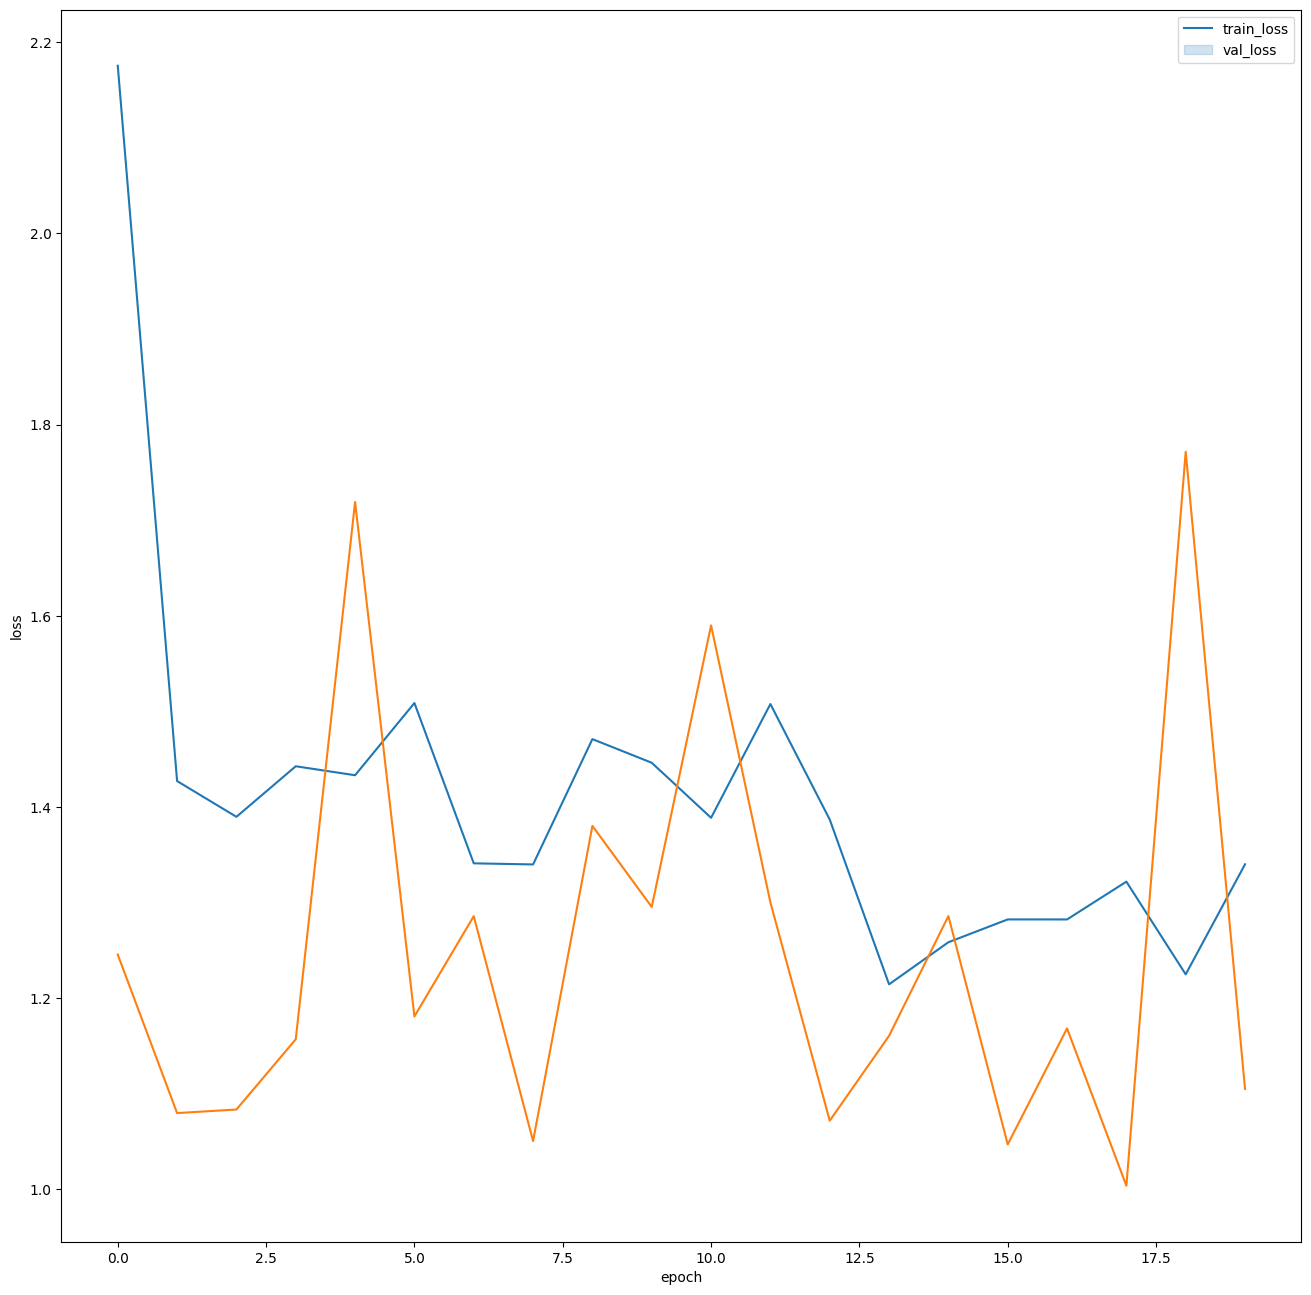

In [49]:
# Evaluate the Model
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

# Plot Train Loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history)

# Plot Validation Loss
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history)

# Add Legends
plt.legend(labels = ['train_loss', 'val_loss'])

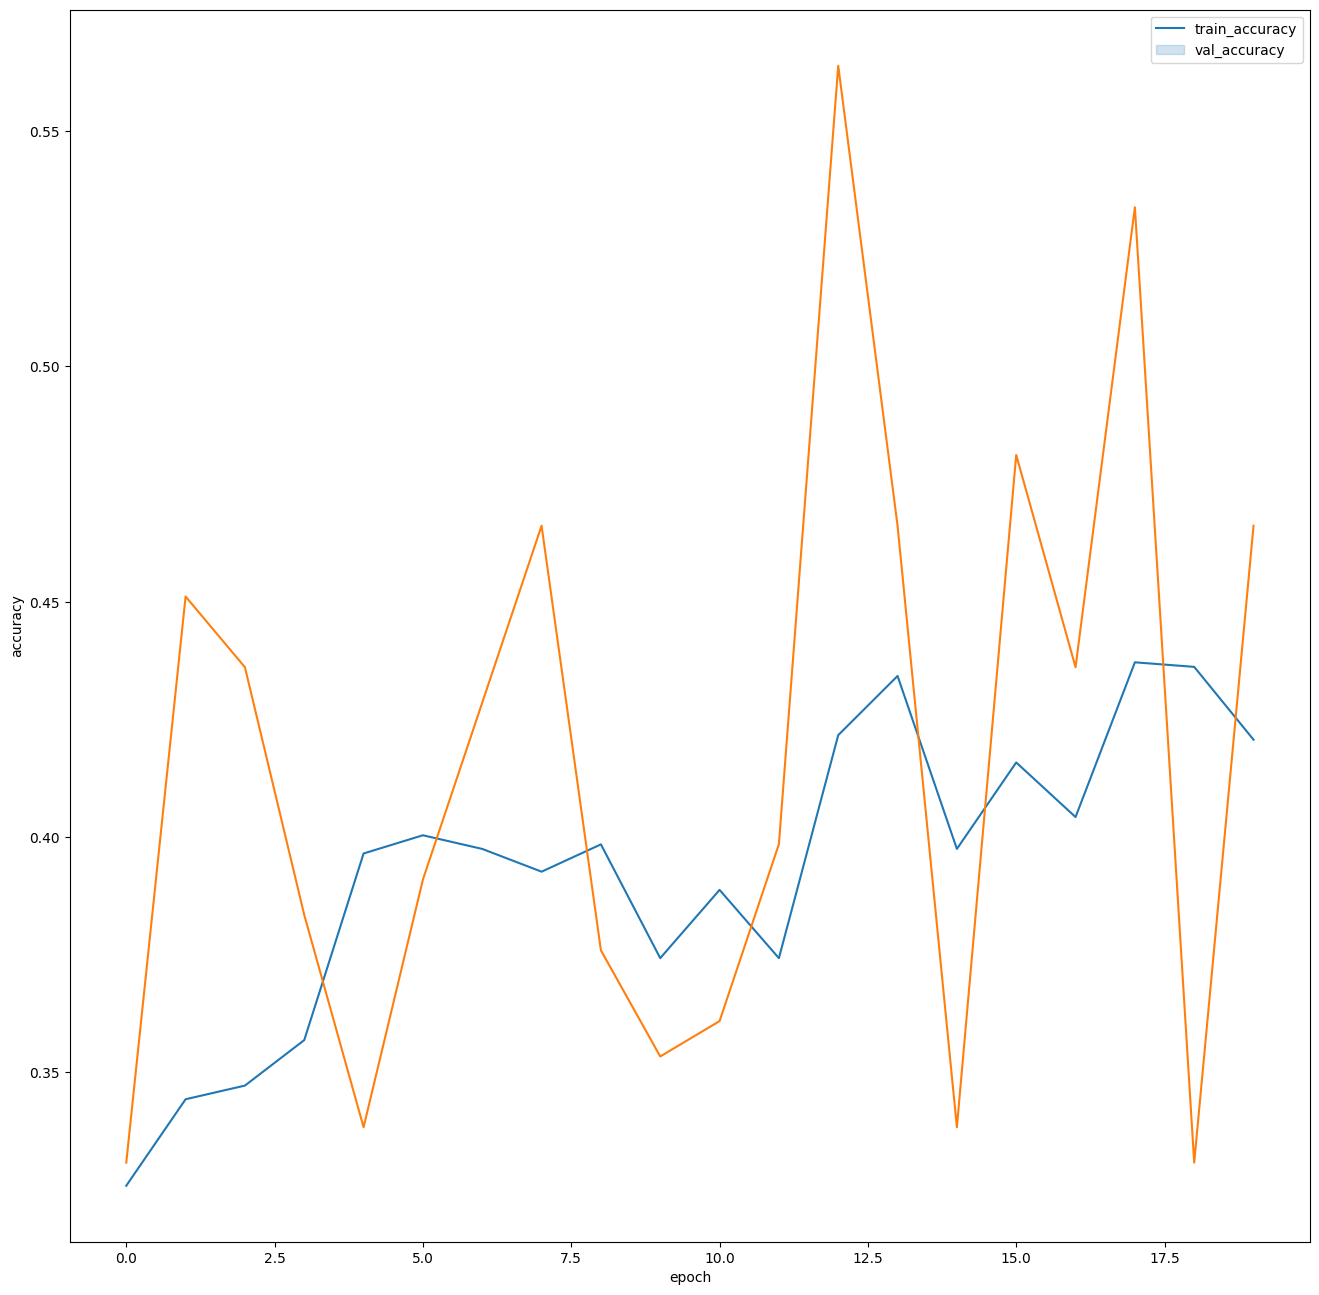

In [50]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history)

# Plot Validation Accuracy Loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history)

# Add Legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

In [51]:
test_loss, test_acc = model.evaluate(bn_test, verbose = 0)

print(f"Test Loss = {test_loss:.2f} & Test Accuracy = {test_acc:.2f}")

Test Loss = 1.08 & Test Accuracy = 0.39
